## 1. 환경 설정

`(1) Env 환경변수`

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [3]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

## 2. Tool 정의

`(1) 사용자 정의 - @tool decorator`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [4]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """레스토랑 메뉴에서 정보를 검색합니다."""
    docs = vector_db.similarity_search(query, k=2)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

`(2) LangChain 내장 도구`
- 일반 웹 검색을 위한 Tavily 초기화

In [5]:
from langchain_community.tools import TavilySearchResults


# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

In [6]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

# 도구 목록
tools = [search_menu, search_web]

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)

In [7]:
from langchain_core.messages import HumanMessage

# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_BzT41jsvKdDBAzuVOUeQ1Sn0', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}


In [8]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
print(tool_call.additional_kwargs)

{'tool_calls': [{'index': 0, 'id': 'call_JQdiWdSlUA3HmAhzK7R8r6HY', 'function': {'arguments': '{"query":"LangGraph"}', 'name': 'search_web'}, 'type': 'function'}]}


In [9]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
print(tool_call.additional_kwargs)

{}


In [10]:
tool_call

AIMessage(content='3 + 3은 6입니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab'}, id='run--cf82d5b2-ecaa-454b-878d-ed8e35bcc610-0')

## 2. 도구 노드(Tool Node) 
- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    - 가장 최근의 AIMessage에서 도구 호출 요청을 추출 (반드시, AIMessage는 반드시 tool_calls가 채워져 있어야 함)
    - 요청된 도구들을 병렬로 실행
    - 각 도구 호출에 대해 ToolMessage를 생성하여 반환

`(1) 도구 노드(Tool Node) 정의`



In [ ]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의 
tool_node = ToolNode(tools=tools)

In [12]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_QM9nOEeMTVVAOdhMa065NJZ1', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab'}, id='run--430d2d9a-f396-4623-8dc6-7d0169e3e464-0', tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_QM9nOEeMTVVAOdhMa065NJZ1', 'type': 'tool_call'}])

`(2) 도구 노드(Tool Node) 실행`


In [13]:
# 도구 호출 결과를 메시지로 추가하여 실행 
results = tool_node.invoke({"messages": [tool_call]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>



In [14]:
# LLM 모델을 이용하여 도구를 호출하여 실행 
results = tool_node.invoke({"messages": [llm_with_tools.invoke("LangGraph는 무엇인가요?")]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

<Document href="https://www.ibm.com/think/topics/langgraph"/>
LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling complex relationships between nodes, which means it uses AI agents to analyze their past actions and feedback.
</Document>

---

<Document href="https

## 3. ReAct Agent
- ReAct(Reasoning and Acting) : 가장 일반적인 에이전트
- 동작 방식:
    - 행동 (act): 모델이 특정 도구를 호출
    - 관찰 (observe): 도구의 출력을 모델에 다시 전달
    - 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

- 논문: https://arxiv.org/abs/2210.03629

`(1) 랭그래프 내장 ReAct 에이전트 사용`

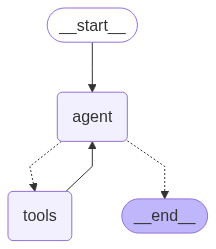

In [15]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent
graph = create_react_agent(
    llm, 
    tools=tools, 
)

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_OYoNAB21hBSTHXLyzE8h0HmG)
 Call ID: call_OYoNAB21hBSTHXLyzE8h0HmG
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>
=======================

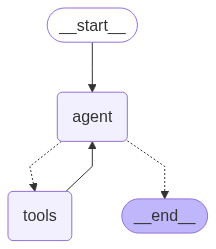

In [17]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# 시스템 프롬프트
system_prompt = dedent("""
You are an AI assistant designed to answer human questions. 
You can use the provided tools to help generate your responses.

Follow these steps to answer questions:
    1. Carefully read and understand the question.
    2. Use the provided tools to obtain necessary information.
    3. Immediately after using a tool, cite the source using the format below.
    4. Construct an accurate and helpful answer using the tool outputs and citations.
    5. Provide the final answer when you determine it's complete.

When using tools, follow this format:
    Action: tool_name
    Action Input: input for the tool

Immediately after receiving tool output, cite the source as follows:
    [Source: tool_name | document_title/item_name | url/file_path]

For example:
    Action: search_menu
    Action Input: 스테이크
    
    (After receiving tool output)
    [Source: search_menu | 스테이크 | ./data/data.txt]
    스테이크에 대한 정보는 다음과 같습니다...

    Action: search_web
    Action Input: History of AI

    (After receiving tool output)
    [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
    AI의 역사는 다음과 같이 요약됩니다...

If tool use is not necessary, answer directly.

Your final answer should be clear, concise, and directly related to the user's question. 
Ensure that every piece of factual information in your response is accompanied by a citation.

Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
Do not provide any information without a corresponding citation.
""")

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=system_prompt,
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_ickpcwYgE6ZNrEgEz9kpOnoX)
 Call ID: call_ickpcwYgE6ZNrEgEz9kpOnoX
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>
=======================

`(2) 조건부 엣지 함수를 사용자 정의`
- `should_continue` 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행 

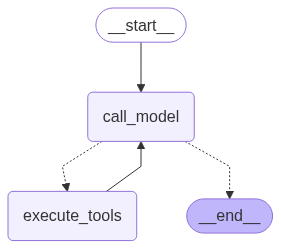

In [19]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_7rIaxt6NlAZwVasN2JgIfpDT)
 Call ID: call_7rIaxt6NlAZwVasN2JgIfpDT
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>
=======================

`(3) tools_condition 활용`
- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수
- 최신 메시지(결과)가 도구 호출이면 -> `tools_condition`이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> `tools_condition`이 `END`로 라우팅

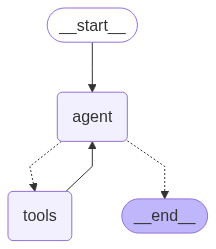

In [21]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="파스타에 어울리는 음료는 무엇인가요?")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_JVDvSNs1PgbRGxKJWxQqu3Yx)
 Call ID: call_JVDvSNs1PgbRGxKJWxQqu3Yx
  Args:
    query: 파스타 음료
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>
================================== Ai Message ================================

## 4. MemorySaver

1. 상태의 일시성 문제:
   - 기본적으로 그래프 실행 시 상태는 일시적 (stateless)
   - 그래프를 재실행하는 경우 상태가 초기화되는 문제가 있음 
   - 따라서, 중단이 있는 다중 턴 대화가 어려움 

2. MemorySaver 기능:
   - 가장 쉽게 사용할 수 있는 체크포인터 (각 단계 후 그래프 상태를 자동으로 저장)
   - 그래프 상태를 위한 인메모리 키-값 저장소
   - 지속성(persistence) 있는 메모리 기능을 제공하여 그래프 객체가 체크포인터부터 이어서 실행 가능 

3. 메모리의 필요성:
   - 대화의 연속성: 여러 턴에 걸친 대화를 유지 
   - 중단 허용: 대화 중 중단이 있어도 이전 상태를 복원
   - 유연한 상태 관리: 다양한 대화 스레드를 독립적으로 관리

### 4-1. 사용자 정의 그래프

In [23]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음 
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = graph.invoke(inputs)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

어떤 항목 중에서 추천을 원하시는지 구체적으로 알려주시면, 그에 맞춰 최선의 선택을 도와드리겠습니다. 예를 들어, 음식, 영화, 책 등 여러 분야가 있을 수 있습니다.


`(1) 체크포인터 지정`
- 그래프를 컴파일할 때 체크포인터를 지정

In [24]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 초기화 
memory = MemorySaver()

# 체크포인터 지정하여 그래프 컴파일 
graph_memory = builder.compile(checkpointer=memory)

`(2) 체크포인터 사용`
- 메모리 사용 시 `thread_id`를 지정 
- 체크포인터는 그래프의 각 단계에서 상태를 기록 (그래프 각 단계의 모든 상태를 컬렉션으로 저장)
- 나중에 `thread_id`를 사용하여 이 스레드에 접근 가능 

In [25]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_xHPaNrIHVKef26xtS6vnezT8)
 Call ID: call_xHPaNrIHVKef26xtS6vnezT8
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>
=======================

In [26]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_xHPaNrIHVKef26xtS6vnezT8)
 Call ID: call_xHPaNrIHVKef26xtS6vnezT8
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>
=======================

### 4-2. 내장 ReAct 

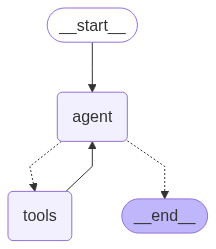

In [27]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=system_prompt,
    checkpointer=memory,
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_1kPROsGqZM95r6HDsfcAhaxD)
 Call ID: call_1kPROsGqZM95r6HDsfcAhaxD
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
5. 가든 샐러드
   • 가격: ₩12,000
   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱
   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 아삭한 식감의 믹스 그린에 달콤한 체리 토마토, 오이, 당근을 더해 다양한 맛과 식감을 즐길 수 있습니다. 특제 발사믹 드레싱이 채소 본연의 맛을 살려줍니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
5. 가든 샐러드
   • 가격: ₩12,000
   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱
   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 아삭한 식감의 믹스 그린에 달콤한 체리 토마토, 오이, 당근을 더해 다양한 맛과 식감을 즐길 수 있습니다. 특제 발사믹 드레싱이 채소 본연의 맛을 살려줍니다.
</Document>
================================== Ai Message ================

In [29]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 대한 출처가 있나요?")]
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_1kPROsGqZM95r6HDsfcAhaxD)
 Call ID: call_1kPROsGqZM95r6HDsfcAhaxD
  Args:
    query: 채식주의자 메뉴
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
5. 가든 샐러드
   • 가격: ₩12,000
   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱
   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 아삭한 식감의 믹스 그린에 달콤한 체리 토마토, 오이, 당근을 더해 다양한 맛과 식감을 즐길 수 있습니다. 특제 발사믹 드레싱이 채소 본연의 맛을 살려줍니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
5. 가든 샐러드
   • 가격: ₩12,000
   • 주요 식재료: 유기농 믹스 그린, 체리 토마토, 오이, 당근, 발사믹 드레싱
   • 설명: 신선한 유기농 채소들로 구성된 건강한 샐러드입니다. 아삭한 식감의 믹스 그린에 달콤한 체리 토마토, 오이, 당근을 더해 다양한 맛과 식감을 즐길 수 있습니다. 특제 발사믹 드레싱이 채소 본연의 맛을 살려줍니다.
</Document>
================================== Ai Message ================

## 5. Gradio 챗봇

In [30]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

# 메모리 사용 준비
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph_memory.invoke(inputs, config=config)
        
        if "messages" in result:
            # 메시지 로깅 (선택사항)
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                msg.pretty_print()

            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content

        return "응답을 생성하지 못했습니다."

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = process_message(message, history, self.thread_id)
        return response

chatbot = ChatBot()


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다. 정보의 출처를 함께 제공합니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [31]:
# 데모 종료
demo.close()

Closing server running on port: 7860
